## Проект исследования прибыльности тарифов мобильного оператора

### 1. Описание проекта

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### 2. Описание тарифов

#### Тариф «Смарт»

- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей
    
#### Тариф «Ультра»

- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей
    
*Примечание:

*«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

*Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

### 3. Описание данных

#### Таблица users (информация о пользователях):
    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tariff — название тарифного плана

#### Таблица messages (информация о сообщениях):
    id — уникальный номер сообщения
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение
    
#### Таблица internet (информация об интернет-сессиях):
    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя

#### Таблица tariffs (информация о тарифах):
    tariff_name — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### 4. Импорт библиотек и данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
pd.set_option('display.max_columns', None)

df_calls = pd.read_csv('/datasets/calls.csv', sep=',')
df_internet = pd.read_csv('/datasets/internet.csv', sep=',')
df_messages = pd.read_csv('/datasets/messages.csv', sep=',')
df_users = pd.read_csv(r'/datasets/users.csv', sep=',')
df_tariffs = pd.read_csv(r'/datasets/tariffs.csv', sep=',')

### 5. Предобработка данных

#### Проверим наличие пропусков

In [3]:
print('Звонки: ', df_calls.isna().sum())
print('Интернет: ', df_internet.isna().sum())
print('Сообщения: ', df_messages.isna().sum())
print('Пользователи: ', df_users.isna().sum())
print('Тарифы: ', df_tariffs.isna().sum())

Звонки:  id           0
call_date    0
duration     0
user_id      0
dtype: int64
Интернет:  Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64
Сообщения:  id              0
message_date    0
user_id         0
dtype: int64
Пользователи:  user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64
Тарифы:  messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64


<div class="alert alert-info">
    Пропуски присутствуют только в таблице Users в столбце Churn_date(дата прекращения пользования тарифом), игнорируем т.к. это действующие пользователи тарифа на момент выгрузки.
    </div>

#### Преобразуем типы данных

In [4]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_calls['duration'] = np.ceil(df_calls['duration'])
df_calls['month'] = df_calls['call_date'].dt.month

df_calls_pivot = df_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])
df_calls_pivot.reset_index()
df_calls_pivot.columns = ['count_calls', 'sum_calls']
display(df_calls_pivot)

count_calls  sum_calls
user_id month                        
1000    5               22      159.0
        6               43      172.0
        7               47      340.0
        8               52      408.0
        9               58      466.0
...                    ...        ...
1498    10              41      247.0
1499    9                9       70.0
        10              68      449.0
        11              74      612.0
        12              69      492.0

[3174 rows x 2 columns]

<div class="alert alert-info">
    Преобразовали столбец с датой и выделили отдельной колонкой месяц для подсчета. Длительность звонков округлили в большую сторону соответственно Условиям тарифов
    </div>

In [5]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_internet['month'] = df_internet['session_date'].dt.month

df_internet_pivot = df_internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
df_internet_pivot['mb_used'] = np.ceil(df_internet_pivot['mb_used'] / 1024)
df_internet_pivot = df_internet_pivot.rename(columns={
    'mb_used': 'gb_sum'
})
df_internet_pivot.reset_index()
display(df_internet_pivot)

gb_sum
user_id month        
1000    5         3.0
        6        23.0
        7        14.0
        8        14.0
        9        15.0
...               ...
1498    10       21.0
1499    9         2.0
        10       18.0
        11       18.0
        12       13.0

[3203 rows x 1 columns]

<div class="alert alert-info">
    Также выделили месяц от даты сессии для подсчетов и округлили количество Мб до Гб в большую сторону соответственно Условиям тарифов
    </div>

In [6]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_messages['month'] = df_messages['message_date'].dt.month

df_messages_pivot = df_messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
df_messages_pivot = df_messages_pivot.rename(columns={
    'id': 'message_count'
})
df_messages_pivot.reset_index()
display(df_messages_pivot)

message_count
user_id month               
1000    5                 22
        6                 60
        7                 75
        8                 81
        9                 57
...                      ...
1498    10                42
1499    9                 11
        10                48
        11                59
        12                66

[2717 rows x 1 columns]

In [7]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users.reset_index()
display(df_users)
df_users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [8]:
df_tariffs.reset_index()
df_tariffs['mb_per_month_included'] = df_tariffs['mb_per_month_included'] / 1024
df_tariffs = df_tariffs.rename(columns={
    'tariff_name': 'tariff',
    'mb_per_month_included': 'gb_per_month_included'
})

display(df_tariffs)
df_tariffs.info()

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   gb_per_month_included  2 non-null      float64
 2   minutes_included       2 non-null      int64  
 3   rub_monthly_fee        2 non-null      int64  
 4   rub_per_gb             2 non-null      int64  
 5   rub_per_message        2 non-null      int64  
 6   rub_per_minute         2 non-null      int64  
 7   tariff                 2 non-null      object 
dtypes: float64(1), int64(6), object(1)
memory usage: 256.0+ bytes


<div class="alert alert-info">
   Преобразовали столбцы с датами. Переименовали столбцы и пересчитали Мб в Гб в Условиях тарифов для удобства дальнейших объединения датасетов и подсчетов.
    </div>

#### Объединим все датасеты в один и добавим расчеты ежемесячных расходов пользователей

In [9]:

df_general = df_internet_pivot.merge(df_calls_pivot, on=('user_id', 'month'), how='outer')
df_general = df_general.merge(df_messages_pivot, on=('user_id', 'month'), how='outer')
df_general.reset_index(inplace=True)

df_general = df_general.merge(df_users, on='user_id', how='outer')
df_general = df_general.merge(df_tariffs, on='tariff', how='outer')

display(df_general)

,user_id,month,gb_sum,count_calls,sum_calls,message_count,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,3.0,22.0,159.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
1,1000,6.0,23.0,43.0,172.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
2,1000,7.0,14.0,47.0,340.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
3,1000,8.0,14.0,52.0,408.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
4,1000,9.0,15.0,58.0,466.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1499,9.0,2.0,9.0,70.0,11.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15.0,500,550,200,3,3
3212,1499,10.0,18.0,68.0,449.0,48.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15.0,500,550,200,3,3
3213,1499,11.0,18.0,74.0,612.0,59.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15.0,500,550,200,3,3
3214,1499,12.0,13.0,69.0,492.0,66.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15.0,500,550,200,3,3


In [10]:
print(df_general.isna().sum()) 

user_id                     0
month                       2
gb_sum                     13
count_calls                42
sum_calls                  42
message_count             499
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
gb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64


<div class="alert alert-info">
    
После объединения возникли пропуски в столбцах с количеством сообщений, звонками, интернет-трафиком. Вероятней всего часть абонентов не использовали интернет-трафик. 
- смс-сообщениями многие не пользуются, ведь сейчас полно мессенджеров, работающих через интернет. 
- по звонкам похожая ситуация, плюс это могут быть пропущенные звонки. 
- по гигабайтам некоторые просто используют телефон без доступа к интернету, ходят с т.н. "тапиками"
    
Лучшим решением будет заполнить их нулевыми значениями.
    
</div>

In [11]:
df_general = df_general.fillna(value=0)
print(df_general.isna().sum()) 

user_id                  0
month                    0
gb_sum                   0
count_calls              0
sum_calls                0
message_count            0
age                      0
churn_date               0
city                     0
first_name               0
last_name                0
reg_date                 0
tariff                   0
messages_included        0
gb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
dtype: int64


In [12]:
def income_per_user(row):
    pay = 0
    if row['sum_calls'] >= row['minutes_included']:
        pay += (row['sum_calls'] - row['minutes_included']) * row['rub_per_minute']        
    if row['message_count'] >= row['messages_included']:
        pay += (row['message_count'] - row['messages_included']) * row['rub_per_message']        
    if row['gb_sum'] >= row['gb_per_month_included']:
        pay += (row['gb_sum'] - row['gb_per_month_included']) * row['rub_per_gb']        
    return pay

df_general['income_per_user'] = df_general.apply(income_per_user, axis=1) + df_general['rub_monthly_fee']
display(df_general)

# с помощью функции посчитаем доход от каждого пользователя по месяцам

,user_id,month,gb_sum,count_calls,sum_calls,message_count,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,income_per_user
0,1000,5.0,3.0,22.0,159.0,22.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
1,1000,6.0,23.0,43.0,172.0,60.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
2,1000,7.0,14.0,47.0,340.0,75.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
3,1000,8.0,14.0,52.0,408.0,81.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
4,1000,9.0,15.0,58.0,466.0,57.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1499,9.0,2.0,9.0,70.0,11.0,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15.0,500,550,200,3,3,550.0
3212,1499,10.0,18.0,68.0,449.0,48.0,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15.0,500,550,200,3,3,1150.0
3213,1499,11.0,18.0,74.0,612.0,59.0,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15.0,500,550,200,3,3,1513.0
3214,1499,12.0,13.0,69.0,492.0,66.0,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15.0,500,550,200,3,3,598.0


### Разобьем пользователей на 2 группы и проанализируем показатели по тарифам

In [13]:
df_smart = df_general[df_general['tariff'] == 'smart']
df_ultra = df_general[df_general['tariff'] == 'ultra']

#### Показатели по использованию интернет-трафика

,mean,std,var
,gb_sum,gb_sum,gb_sum
tariff,,,
smart,16.322,5.756,33.133
ultra,19.475,9.868,97.379


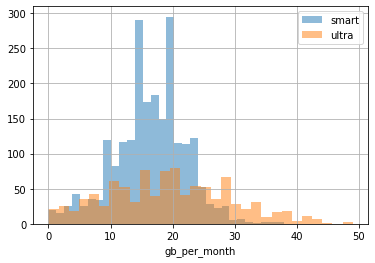

In [14]:
display(df_general.pivot_table(index='tariff', values='gb_sum', aggfunc=['mean', 'std', 'var']).round(3))

df_smart['gb_sum'].hist(bins=30, alpha=0.5)
df_ultra['gb_sum'].hist(bins=30, alpha=0.5)
plt.xlabel('gb_per_month')
plt.legend(['smart', 'ultra'])

<div class="alert alert-info">
    
Пользователи тарифа Smart: 
- по среднему значению потребления трафика превышают на ~2 Гб от базового пакета в 15Гб, включенного в абонентскую плату, с отклонением в +-6Гб. На гистограмме это видно, основная масса абонентов расходует от 9 до 24Гб трафика. Значительная часть пользователей тарифа превышает пакет в 15Гб и расходуют от 2 до 10Гб платного трафика.

Пользователи тарифа Ultra:
- потребляют в среднем 2/3 трафика, включенного в абонентскую плату. Однако, судя по распределению на гистограмме нет четкого диапазона по расходованию. Если взять за порог 50 пользователей, то можно выделить диапазон от 10 до 29 Гб. Из этого следует, что почти все пользователи тарифа не превышают пакета в 30Гб, включенного в абонентскую плату.

</div>

#### Показатели по длительности разговоров

,mean,std,var
,sum_calls,sum_calls,sum_calls
tariff,,,
smart,417.75,190.48,36281.39
ultra,526.09,317.89,101052.49


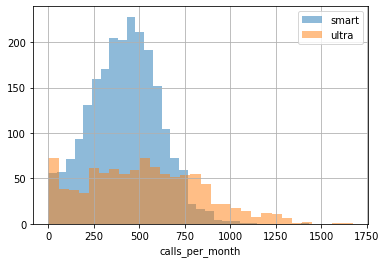

In [15]:
display(df_general.pivot_table(index='tariff', values='sum_calls', aggfunc=['mean', 'std', 'var']).round(2))

df_smart['sum_calls'].hist(bins=30, alpha=0.5)
df_ultra['sum_calls'].hist(bins=30, alpha=0.5)
plt.xlabel('calls_per_month')
plt.legend(['smart', 'ultra'])

<div class="alert alert-info">
    
Пользователи тарифа Smart: 
- средний показатель продолжительности звонков не превышает пакет 500 минут, включенный в абонентскую плату. Стандартное отклонение и гистограмма говорят о значительной части пользователей, превышающих базовый пакет до +250 минут. При этом распределение показывает, что основная часть пользователей (если взять порог - от 50 абонентов), расходует от 50 до 750 минут.
Корзина с 0 значениями, строки с пропусками.

Пользователи тарифа Ultra:
- в среднем пользователи расходуют чуть более половины пакета 1000 мин., включенный в абонентскую плату, значение схоже со средним у абонентов Smart. Стандартное отклонение и гистограмма говорят о том, что почти все абоненты не превышают базовый пакет минут. Основной диапазон (если взять порог - от 50 абонентов), расходуют от 200 до 850 минут.
Корзина с 0 значениями, строки с пропусками.
    
</div>

#### Показатели по количеству сообщений

,mean,std,var
,message_count,message_count,message_count
tariff,,,
smart,33.37,28.23,796.96
ultra,49.31,47.81,2285.42


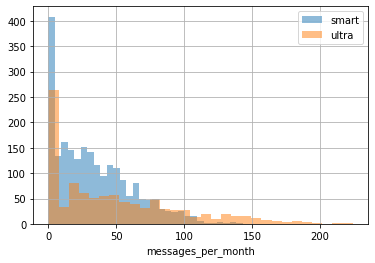

In [16]:
display(df_general.pivot_table(index='tariff', values='message_count', aggfunc=['mean', 'std', 'var']).round(2))

df_smart['message_count'].hist(bins=30, alpha=0.5)
df_ultra['message_count'].hist(bins=30, alpha=0.5)
plt.xlabel('messages_per_month')
plt.legend(['smart', 'ultra'])

<div class="alert alert-info">
    
Пользователи тарифа Smart: 
- по показателям мы видим, что пользователи относительно редко пользуются смс-сообщениями. 
- при среднем значении около 34, разница с отклонением составляет 28 сообщений, значит есть резкое разделение среди пользователей на тех кто пользуется смс, и тех пользуется ими редко. 
- распределение здесь скошено вправо, из-за большого количества малых значений в выборке и незначительного количества больших значений. 
- однако у довольно большая часть абонентов превышает базовый пакет в 50 сообщений, дополнительные +50-100 смс

Пользователи тарифа Ultra:
- по показателям мы видим, что пользователи тарифа Ultra отправляют сообщения чаще, чем абоненты Smart. 
- при среднем значении около 60, также наблюдается небольшая разница с отклонением составляет всего 14 сообщений. 
- и распределение также скошено вправо, из-за большого количества малых значений в выборке и незначительного количества больших значений.
- все абоненты не превышают базовый пакет в 1000 сообщений, и используют максимум чуть более 200 смс
    
</div>

,mean,std,var
,income_per_user,income_per_user,income_per_user
tariff,,,
smart,1289.64,818.37,669730.76
ultra,2070.03,376.02,141387.71


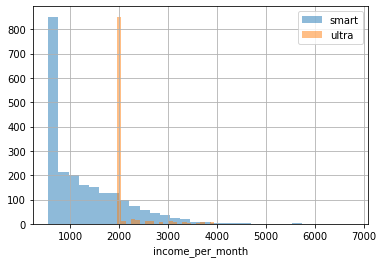

In [17]:
display(df_general.pivot_table(index='tariff', values='income_per_user', aggfunc=['mean', 'std', 'var']).round(2))

df_smart['income_per_user'].hist(bins=30, alpha=0.5)
df_ultra['income_per_user'].hist(bins=30, alpha=0.5)
plt.xlabel('income_per_month')
plt.legend(['smart', 'ultra'])

<div class="alert alert-info">
    
Пользователи тарифа Smart: 
- по показателям мы видим, что как минимум половина пользователей расходуют не больше абонентской платы. 
- график скошен вправо, при среднем значении расходов около 1300, с отклонением около 800 говорит о значительном количестве выбросов в большую сторону.  
- при этом относительно пользователей тарифа Ultra, пользователи Smart намного чаще превышают расходы, в разы больше абонентской платы

Пользователи тарифа Ultra:
- пользователи тарифа Ultra практически всегда укладываются в расходы, не более абонентской платы. 
- среднее значение 2070 близко к сумме абоненсткой в 1950, с незначительным отклонением менее 400 руб. 
- и распределение также скошено вправо, из-за малого количества значений в выборке и незначительного количества выбросов в большую сторону.
    
</div>

In [18]:
display(df_general.pivot_table(index=['tariff', 'month'], values=['gb_sum', 'sum_calls', 'message_count', 'income_per_user']).round(2))

gb_sum  income_per_user  message_count  sum_calls
tariff month                                                   
smart  0.0      0.00           550.00           0.00       0.00
       1.0      8.74           721.32          18.24     203.85
       2.0     11.84           827.60          24.09     298.69
       3.0     15.23          1164.62          31.86     390.05
       4.0     13.62           963.09          30.74     367.13
       5.0     15.91          1197.51          33.77     387.36
       6.0     15.95          1204.02          33.40     395.64
       7.0     15.88          1223.95          33.75     408.35
       8.0     16.74          1320.60          33.64     421.47
       9.0     16.39          1249.95          33.64     428.61
       10.0    16.88          1364.85          33.77     426.14
       11.0    17.00          1343.05          34.08     435.27
       12.0    18.20          1578.53          35.99     478.56
ultra  0.0      0.00          1950.00           0.00       0.00
       1.0     13.22          1950.00          33.78     428.11
       2.0     12.00          1975.00          21.96     297.12
       3.0     17.65          2014.86          32.30     489.65
       4.0     16.96          2001.82          31.56     458.02
       5.0     19.37          2059.70          37.85     510.33
       6.0     18.94          2039.29          41.73     479.70
       7.0     20.51          2118.13          49.85     545.79
       8.0     19.60          2083.18          48.44     510.78
       9.0     19.24          2024.35          52.29     539.44
       10.0    20.07          2065.85          58.43     558.08
       11.0    19.81          2092.16          55.79     541.38
       12.0    21.74          2138.85          60.61     592.81

<div class="alert alert-info">
    
Показатели по месяцам:
    
У пользователей обоих тарифов наблюдается рост среднего потребления трафика от начала до конца года примерно в 1.5 - 2 раза. Здесь явно влияют общая тенденция активности людей и экономики в целом
- новогодние каникулы
- снижение активности населения и доходов
- к весне рост активности населения и рынка 
- в летний период небольшая коррекция на снижение 
- далее начало учебного года 
- ближе к концу года: завершение дел, проектов и отчетов, подготовка к праздникам

</div>

### Проверим гипотезы
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

#### Применим двусторнний статистический тест на равенство двух генеральных совокупностей, т.к. имеем 2 массива данных и хотим проверить насколько схожи средние показатели доходов от двух тарифов 

- нулевая гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны
- альтернативная гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

In [19]:
smart_income = df_smart['income_per_user']
ultra_income = df_ultra['income_per_user']
alpha = .05 # критический уровень статистической значимости
            

results = st.ttest_ind(
    smart_income, 
    ultra_income)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 8.081909555489933e-161
Отвергаем нулевую гипотезу


<div class="alert alert-info">
    
#### В результате полученного значения р_value мы отвергаем нулевую гипотезу о равенстве средних доходов от пользователей тарифов Smart и Ultra
    
</div>

#### Применим двусторнний статистический тест на равенство двух генеральных совокупностей, т.к. имеем 2 массива данных и хотим проверить насколько схожи средние показатели доходов от пользователей из Москвы и из остальных регионов.

- нулевая гипотеза: средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.
- альтернативная гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [20]:
moscow_income = df_general[df_general['city'] == 'Москва']['income_per_user']
reg_income = df_general[df_general['city'] != 'Москва']['income_per_user']
alpha = .05 # критический уровень статистической значимости
            

results = st.ttest_ind(
    moscow_income, 
    reg_income)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5400751614511182
Не получилось отвергнуть нулевую гипотезу


<div class="alert alert-info">
    
#### В результате полученного значения р_value мы не отвергаем нулевую гипотезу о равенстве средних доходов от абонентов из Москвы и средних доходах от абонентов из остальных регионов
    
</div>

## Общие выводы:

#### Smart
    - значительная часть пользователей тарифа Смарт часто превышают базовые пакеты, и расходуют (мин. +250 \смс +50-100 \Гб +4-9) за дополнительную плату, что приносит столько же либо больше прибыли чем от пользователей Ультра.
    - при этом если пользователь Смарт следит за своими расходами, и они регулярно превышают либо равны стоимости тарифа Ультра, то с большой вероятностью он поменяет тариф.
    - хоть и для оператора Смарт в таких случаях будет прибыльнее, чем Ультра, необходимо учитывать психологический фактор и выявить отношение этих пользователей к перерасходам. Возможно они будут иметь негативный характер и снижать лояльность к бренду.
    - Смарт более популярен среди пользователей оператора. Основные факторы: 
        - бюджетная абонентская плата, 
        - приемлемый размер базовых пакетов для не особо активных пользовалей услуг, 
        - возможность не переплачивать в периоды неактивного пользования услуг
        

#### Ultra
    - пользователи тарифа Ультра почти всегда укладываются в базовые пакеты (минут, смс и Гб), включенные в абонентскую плату, значит расходы для пользователей этого тарифа имеют стабильный характер и скорее всего повышают лояльность к бренду, приводя привычный характер использования тарифа у абонента. 
    - Также несмотря на то, что количество пользователей Ультра в несколько раз уступает количеству абонентов Смарт, доходность от пользователей Ультра в разы не отличается.
    - По своей структуре пользователи тарифа формируют более стабильный и состоятельный сегмент абонентов, готовых также тратить больше на дополнительные и смежные услуги оператора, например домашний интернет и кабельное ТВ.



#### Исходя из вышеперечисленного тариф Ультра более выгоден для оператора ввиду своей стабильной прибыльности и качестве абонентов, однако тариф Смарт необходим для более массового привлечения новых абонентов, часть из которых перейдут со временем на Ультра и станут более лояльными клиентами, а также формирования двух сегментов пользователей:
    - те которым нужны небольшие объемы услуг и бюджетная обонентская плата
    - и те которым важна стабильность расходов и достаточно большой объем услуг